In [1]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

/Users/dormann/Documents/GitHub/src


In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
LSK = np.array(pd.read_csv ('../data/processed_data/LSK.csv'))
y = np.array(LSK[:,-1],dtype=int)
LSK = LSK[:,0:-1]

3

In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSK,y)

In [5]:
print(LSK.shape, len(pred))
acc = model.score_
print(acc)

(3383, 7570) 3383
0.05939139559286464


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (283.0, 4482.0, 0.06314145470771977, 0.32678983833718245, 0.995265014457447, 0.05939139559286464, 0.9993815452246381, 0.9406086044071353, 0.6732101616628176)


# Mutual information maximizer (MIM)

test 0.15856423600945915 0.014037291999837494
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (350.0, 3870.0, 0.09043927648578812, 0.28112449799196787, 0.9973041541104336, 0.08293838862559241, 0.9993752473706291, 0.9170616113744076, 0.7188755020080321)


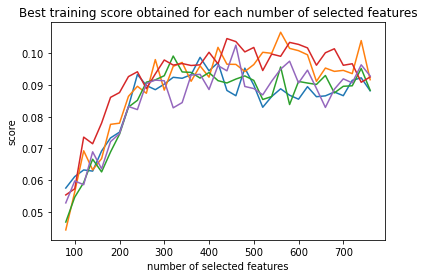

In [7]:
#Define parameters for MIM method
N = np.arange(80,768,20)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSK, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

# Anova F test

test 0.19432911073508197 0.01161584317199877
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (452.0, 3472.0, 0.13018433179723501, 0.2886334610472541, 0.9980884225687262, 0.11518858307849134, 0.9993858682439305, 0.8848114169215087, 0.7113665389527458)


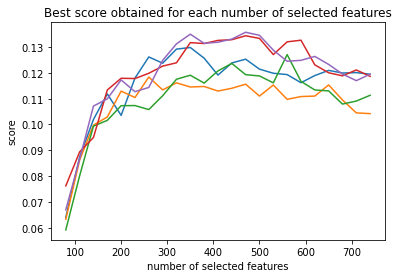

In [8]:
#Define parameters for ANOVA method
N = np.arange(80,768,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSK, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    

In [9]:
#Create .csv with names of this subset
best_subset = subset
get_best_genes_names(best_subset, '../data/processed_data/LSKgenes_interest.csv', '../data/optimized_subsets/LSKgenes_best.csv')

# Hybrid methods

# Mutual information and stimulated annealing

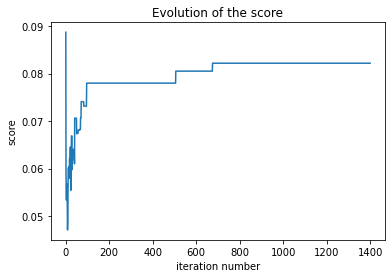

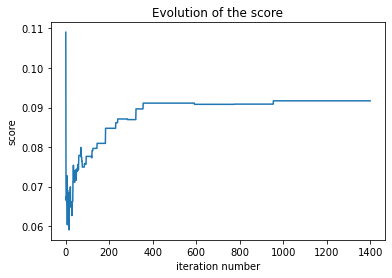

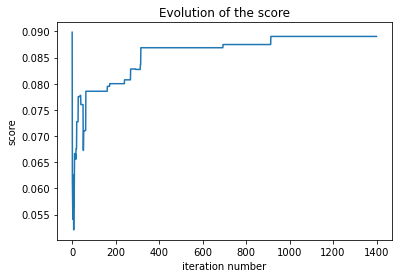

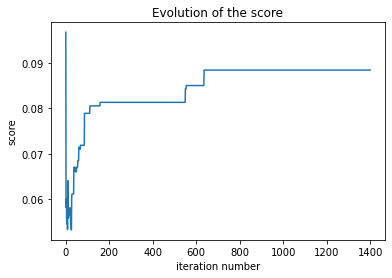

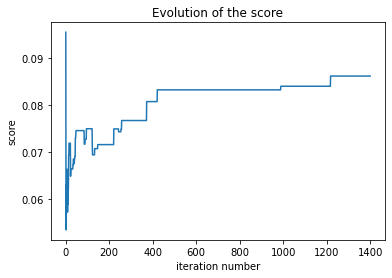

test 0.13103591531270026 0.01892064566525859
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (341.0, 4174.0, 0.08169621466219454, 0.3451417004048583, 0.9961730331783537, 0.07552602436323366, 0.9994048681235593, 0.9244739756367664, 0.6548582995951417)


In [10]:
#Define parameters for MI + stimulated annealing method
N = np.array([700])
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_iter': 1400, 'n_neighbors': 3, 'p_mutate': 0.1, 'c': 1, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSK, FamiliesClusters, compute_precision,True, 5,  MI_stimulated_annealing, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 

# Mutual information and genetic feature selection

In [ ]:
#Define parameters for MI + genetic algorithm method
N = np.array([700])                            
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'n_population': 300, 'crossover_proba': 0.5, 'mutation_proba': 0.2, 'n_generations': 120, 'tournament_size': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,LSK, FamiliesClusters, compute_precision,True, 5,  MI_genetic_fs, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = LSK[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred)) 

# Create csv file with best subset gene

In [ ]:
N = np.arange(80,400,10)
best_subset, best_score = ANOVA(y, LSK, FamiliesClusters, compute_sensitivity,True,N,plot=True)

In [ ]:
#Create .csv with names of this subset
get_best_genes_names(best_subset, '../data/processed_data/LSKgenes_interest.csv', '../data/optimized_subsets/LSKgenes_best.csv')

In [ ]:
print(len(best_subset))